In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from collections import defaultdict
from IPython.display import clear_output
import sys
sys.path.append("ComputeCanada/frequency_tagging")
sys.path.append("/opt/supervenn")
from supervenn import supervenn
from utils import (
    get_roi_colour_codes,
    change_font,
    HCP_ATLAS as hcp_label,
    im_generate_single_subject_maps,
    NORMAL_3T_SUB_IDS,
    NORMAL_7T_SUB_IDS,
    VARY_SUB_IDS,
    VARY_020_ENTRAIN_CONDITIONS,
    VARY_021_ENTRAIN_CONDITIONS,
    PICKLE_DIR,
    get_frequency_text_codes,
    MAIN,
)
change_font()

tmpdir = Path("/tmp")

Get HCP info
- `hcp_mappings`: dict of ROI: dscalars

In [2]:
"""Get HCP labels
"""
_HCP_INFO = !wb_command -file-information {hcp_label}
HCP_LABELS = []
HCP_COUNTER = 0
for i in _HCP_INFO:
    if len(i) == 60 and any(["L_" in i, "R_" in i]):
        hcp_colors = tuple([float(f"0.{k}") for k in [j.split(' ') [0] for j in i.split('0.')][-3:]] + [1])
        if ' R_' in i:
            roi = i.split("_ROI")[0].split(' R_')[1]
            HCP_LABELS.append(f"R_{roi}_ROI")
        if ' L_' in i:
            roi = i.split("_ROI")[0].split(' L_')[1]
            HCP_LABELS.append(f"L_{roi}_ROI")
        HCP_COUNTER += 1

"""Get HCP label coordinates
"""
hcp_mapping = {}
for roi_label in HCP_LABELS:
    out_dscalar = tmpdir / f"{roi_label}.dscalar.nii"
    if out_dscalar.exists():
        hcp_mapping[roi_label] = out_dscalar
        continue
    !wb_command -cifti-label-to-roi {hcp_label} {out_dscalar} -name {roi_label}
    assert out_dscalar.exists(), f"{out_dscalar.stem} does not exist."
    hcp_mapping[roi_label] = out_dscalar
hcp_rois = list(set([k.split('_')[1] for k in hcp_mapping.keys()]))

Generate intermodulation maps:
- Runtime: `corr_types = ["uncp"]`: 827 minutes

In [3]:
"""Set up for visualizing dual frequency tagging across each subject using fractional overlap
"""
ROI_FO = .8
corr_type = "uncp"
FORCE_RUN = False

"""Save png
"""
im_map_pkl = PICKLE_DIR / f"im_map_fo-{ROI_FO}_corr-{corr_type}.pkl"
im_map_proportion_pkl = PICKLE_DIR / f"im_map_proportion_fo-{ROI_FO}_corr-{corr_type}.pkl"
if im_map_pkl.exists() and im_map_proportion_pkl.exists() and not FORCE_RUN:
    df = pd.read_pickle(im_map_pkl)
    proportion_df = pd.read_pickle(im_map_proportion_pkl)
else:
    # 3T control/entrain
    label = "3TNormal"
    df_data = None
    proportion_data = None
    for _roi_task_id in ["control","entrain"]:
        experiment_id = "1_frequency_tagging" 
        mri_id = "3T"
        n_subjects = len(NORMAL_3T_SUB_IDS)
        roi_task_ids = [_roi_task_id] * n_subjects
        roi_f_1s = [.125] * n_subjects
        roi_f_2s = [.2] * n_subjects
        df_data, proportion_data = im_generate_single_subject_maps(
            hcp_mapping,
            label, experiment_id, mri_id, NORMAL_3T_SUB_IDS, 
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO, HCP_LABELS,
            df_data=df_data,
            proportion_data=proportion_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO,
        )
        clear_output()
    # 7T AttendAway
    label = "7TNormal"
    experiment_id = "1_attention" 
    mri_id = "7T"
    n_subjects = len(NORMAL_7T_SUB_IDS)
    roi_task_ids = ["AttendAway"] * n_subjects
    roi_f_1s = [.125] * n_subjects
    roi_f_2s = [.2] * n_subjects
    df_data, proportion_data = im_generate_single_subject_maps(
        hcp_mapping,
        label, experiment_id, mri_id, NORMAL_7T_SUB_IDS, 
        roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO, HCP_LABELS,
        df_data=df_data,
        proportion_data=proportion_data,
        corr_type=corr_type,
        ROI_FO=ROI_FO
    )
    clear_output()
    # 3T/7T vary
    experiment_id = "1_frequency_tagging"
    for label, mri_id in zip(["3TVary","7TVary"], ["3T","7T"]):
        sub_ids = [VARY_SUB_IDS[0]] * 3 + [VARY_SUB_IDS[1]] * 3
        roi_task_ids = [i[0] for i in VARY_020_ENTRAIN_CONDITIONS] + [i[0] for i in VARY_021_ENTRAIN_CONDITIONS]
        roi_f_1s = [i[1] for i in VARY_020_ENTRAIN_CONDITIONS] + [i[1] for i in VARY_021_ENTRAIN_CONDITIONS]
        roi_f_2s = [i[2] for i in VARY_020_ENTRAIN_CONDITIONS] + [i[2] for i in VARY_021_ENTRAIN_CONDITIONS]
        df_data, proportion_data = im_generate_single_subject_maps(
            hcp_mapping,
            label, experiment_id, mri_id, sub_ids,
            roi_task_ids, roi_f_1s, roi_f_2s, ROI_FO, HCP_LABELS,
            df_data=df_data,
            proportion_data=proportion_data,
            corr_type=corr_type,
            ROI_FO=ROI_FO,
        )
        clear_output()
        
    df = pd.DataFrame(df_data)
    df.to_pickle(im_map_pkl)
    proportion_df = pd.DataFrame(proportion_data)
    proportion_df.to_pickle(im_map_proportion_pkl)

Generate f1, f2, 2f1, 2f2, f2-f1, f1+f2, 2f1-f2, 2f2-f1 locked maps across MRI strength and varying entrainment experiments
- sub_ids = 020, 021

In [4]:
from utils import (
    load_mean_dtseries,
    WORKING_DIR,
    crop_and_save,
)

from wbplot import dscalar

DFM_VARY_LOCKED_MAPS = WORKING_DIR / "figures" / "intermodulation_mapping" / "locked_vary_maps"
if not DFM_VARY_LOCKED_MAPS.exists():
    DFM_VARY_LOCKED_MAPS.mkdir(parents=True, exist_ok=True)

VERTEX_TO = 59412
PALETTE_PARAMS = {
    "disp-zero": False,
    "disp-neg": False,
    "disp-pos": True,
    "pos-user": (0, 1.),
    "neg-user": (-1,0),
    "interpolate": True,
}
# Cropped settings
LEFT=590;TOP=80;RIGHT=1140;BOTTOM=460


/tmp/ipykernel_7109/3644749467.py:20: RuntimeWarning: invalid value encountered in scalar divide
  dice_coeff = 2 * intersection / (matrix1.sum() + matrix2.sum())


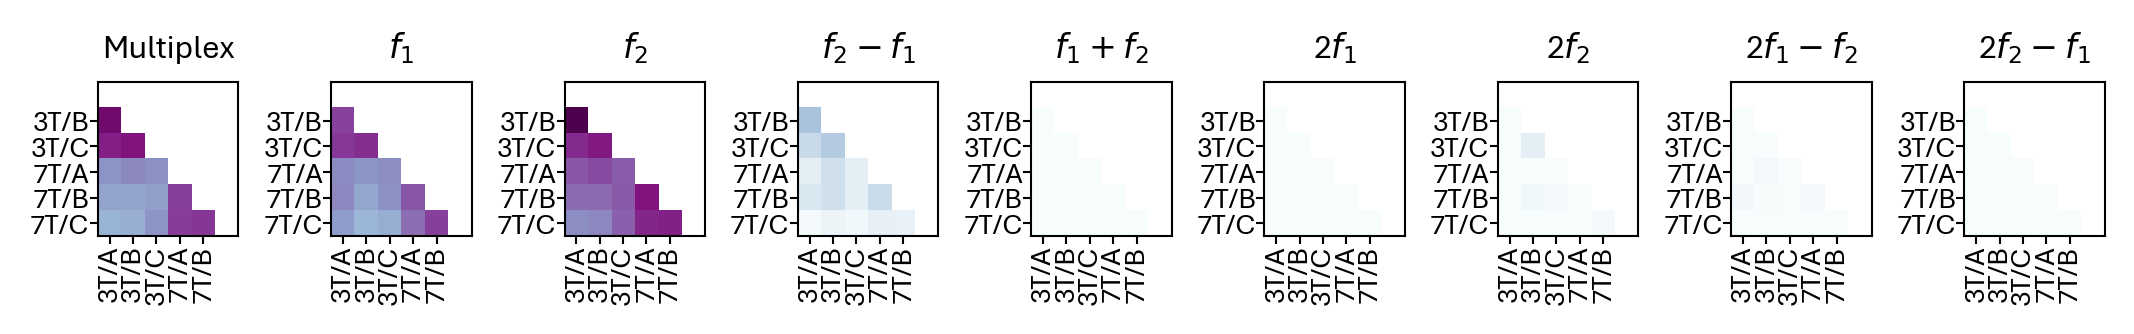

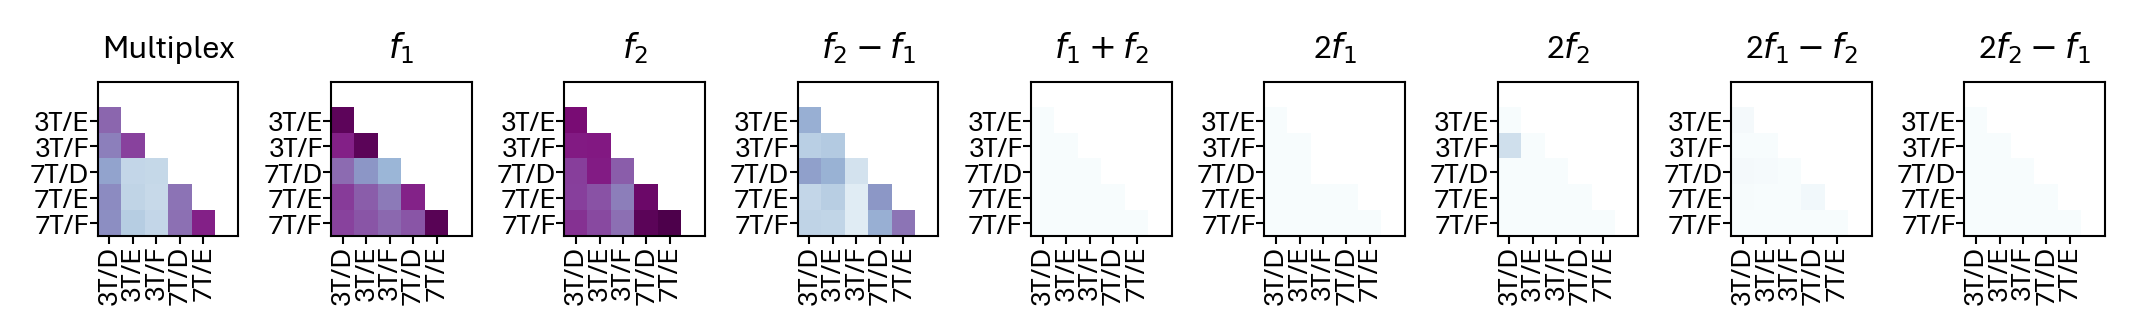

In [10]:
def dice_coefficient(matrix1, matrix2):
    """V
    Compute the Dice coefficient between two binary matrices.
    
    Parameters:
    matrix1 (numpy array): First binary matrix.
    matrix2 (numpy array): Second binary matrix.
    
    Returns:
    float: Dice coefficient between matrix1 and matrix2.
    """
    # Ensure the input matrices are binary
    matrix1 = np.asarray(matrix1).astype(bool)
    matrix2 = np.asarray(matrix2).astype(bool)
    
    # Compute the intersection
    intersection = np.logical_and(matrix1, matrix2).sum()
    
    # Compute the Dice coefficient
    dice_coeff = 2 * intersection / (matrix1.sum() + matrix2.sum())
    
    return dice_coeff


expected_n_runs = 6

data_dict = {}
for sub_id in ["020", "021"]:

    if sub_id == "020":
        entrain_conditions = [i[0] for i in VARY_020_ENTRAIN_CONDITIONS]
    elif sub_id == "021":
        entrain_conditions = [i[0] for i in VARY_021_ENTRAIN_CONDITIONS]

    entrain_2f1_sub_f2 = []
    entrain_f2_sub_f1 = []
    entrain_f1 = []
    entrain_2f1 = []
    entrain_2f2_sub_f1 = []
    entrain_f2 = []
    entrain_f1_add_f2 = []
    entrain_2f2 = []
    entrain1_activations = !ls /scratch/fastfmri/*merged*IM*roi-entrain*uncp*/sub-{sub_id}/bootstrap/*task-{entrain_conditions[0]}*data-train*activations*
    if sub_id == "020":
        entrain_lists = [entrain_2f1_sub_f2, entrain_f2_sub_f1, entrain_f1, entrain_2f1, entrain_2f2_sub_f1, entrain_f2, entrain_f1_add_f2, entrain_2f2]
    else:
        entrain_lists = [entrain_2f1_sub_f2, entrain_f2_sub_f1, entrain_f1, entrain_2f1, entrain_2f2_sub_f1, entrain_f2, entrain_f1_add_f2, entrain_2f2]
    for ix, _entrain_list in enumerate(entrain_lists):
        _entrain_list += [ entrain1_activations[ix], entrain1_activations[ix+8] ]

    entrain2_activations = !ls /scratch/fastfmri/*merged*IM*roi-entrain*uncp*/sub-{sub_id}/bootstrap/*task-{entrain_conditions[1]}*data-train*activations*
    if sub_id == "020":
        entrain_lists = [entrain_f2_sub_f1, entrain_2f1_sub_f2, entrain_f1, entrain_f2, entrain_2f2_sub_f1, entrain_2f1, entrain_2f2, entrain_f1_add_f2]
    else:
        entrain_lists = [entrain_f2_sub_f1, entrain_f1, entrain_2f1_sub_f2, entrain_2f2_sub_f1, entrain_f2, entrain_f1_add_f2, entrain_2f1, entrain_2f2]
    for ix, _entrain_list in enumerate(entrain_lists):
        _entrain_list += [ entrain2_activations[ix], entrain2_activations[ix+8] ]

    entrain3_activations = !ls /scratch/fastfmri/*merged*IM*roi-entrain*uncp*/sub-{sub_id}/bootstrap/*task-{entrain_conditions[2]}*data-train*activations*
    if sub_id == "020":
        entrain_lists = [entrain_f2_sub_f1, entrain_f1, entrain_f2, entrain_2f2_sub_f1, entrain_2f1_sub_f2, entrain_2f1, entrain_f1_add_f2, entrain_2f2]
    else:
        entrain_lists = [entrain_f2_sub_f1, entrain_2f1_sub_f2, entrain_f1, entrain_2f2_sub_f1, entrain_f2, entrain_2f1, entrain_f1_add_f2, entrain_2f2]
    for ix, _entrain_list in enumerate(entrain_lists):
        _entrain_list += [ entrain3_activations[ix], entrain3_activations[ix+8] ]

    assert len(entrain_f1) == expected_n_runs == len(entrain_f2) == len(entrain_2f1_sub_f2) == len(entrain_2f1) == len(entrain_2f2_sub_f1) == len(entrain_f2) == len(entrain_f1_add_f2) == len(entrain_2f2)

    for entrain_descriptor, entrain_f in zip(
        ["f1","f2","2f1_sub_f2","2f1","2f2_sub_f1","f2_sub_f1","f1_add_f2","2f2"],
        [entrain_f1, entrain_f2,entrain_2f1_sub_f2,entrain_2f1,entrain_2f2_sub_f1,entrain_f2_sub_f1,entrain_f1_add_f2,entrain_2f2]
    ):
        
        print(sub_id, entrain_descriptor)
        png_out = DFM_VARY_LOCKED_MAPS / f"sub-{sub_id}_{entrain_descriptor}.png"
        for ix, activation in enumerate(entrain_f):
            _data = (load_mean_dtseries(activation)[:VERTEX_TO] > .8).astype(float)
            if ix == 0:
                data = _data
            else:
                data += _data
        data /= 6
        dscalar(
            png_out, data, 
            orientation="portrait", 
            hemisphere='right',
            palette="magma", 
            palette_params=PALETTE_PARAMS,
            transparent=False,
            flatmap=True,
            flatmap_style='plain',
        )
        crop_and_save(png_out, str(png_out).replace("png", "cropped.png"), LEFT, TOP, RIGHT, BOTTOM)
        clear_output()
        
    mosaic = ["multiplex","f1","f2","f2_sub_f1","f1_add_f2","2f1","2f2","2f1-f2","2f2-f1"]
    fig, ax_dict = plt.subplot_mosaic([mosaic],figsize=(7,1), dpi=300,layout="constrained")
    dcoeff_dict = {}
    for ix, (entrain_descriptor, entrain_f) in enumerate(zip(
        mosaic,
        [
            [entrain_f1, entrain_f2],
            entrain_f1, 
            entrain_f2,
            entrain_f2_sub_f1,
            entrain_f1_add_f2,
            entrain_2f1,
            entrain_2f2,
            entrain_2f1_sub_f2,
            entrain_2f2_sub_f1,
        ]
    )):
        if entrain_descriptor == "multiplex":
            entrain_f1 = entrain_f[0]
            entrain_f2 = entrain_f[1]
            entrain_f1.sort()
            entrain_f2.sort()
            dcoeff = np.zeros((len(entrain_f1), len(entrain_f1)))
            for ix, (dscalarf1_1,dscalarf2_1) in enumerate(zip(entrain_f1,entrain_f2)):
                for iy, (dscalarf1_2,dscalarf2_2) in enumerate(zip(entrain_f1,entrain_f2)):
                    if ix <= iy:
                        dcoeff[ix,iy] = np.nan
                        continue
                    X1 = np.array(nib.load(dscalarf1_1).get_fdata())
                    X2 = np.array(nib.load(dscalarf2_1).get_fdata())
                    Y1 = np.array(nib.load(dscalarf1_2).get_fdata())
                    Y2 = np.array(nib.load(dscalarf2_2).get_fdata())
                    X = (( (X1.mean(0) >= .8).astype(int) + (X2.mean(0) >= .8).astype(int) ) == 2).astype(int)
                    Y = (( (Y1.mean(0) >= .8).astype(int) + (Y2.mean(0) >= .8).astype(int) ) == 2).astype(int)
                    dcoeff[ix,iy] = dice_coefficient(X,Y)
            dcoeff_dict[entrain_descriptor] = dcoeff
        else:
            entrain_f.sort()
            dcoeff = np.zeros((len(entrain_f), len(entrain_f)))
            for ix, dscalar1 in enumerate(entrain_f):
                for iy,dscalar2 in enumerate(entrain_f):
                    if ix <= iy:
                        dcoeff[ix,iy] = np.nan
                        continue
                    X = np.array(nib.load(dscalar1).get_fdata())
                    Y = np.array(nib.load(dscalar2).get_fdata())
                    X = (X.mean(0) >= .8).astype(int)
                    Y = (Y.mean(0) >= .8).astype(int)
                    dcoeff[ix,iy] = dice_coefficient(X,Y)
            dcoeff_dict[entrain_descriptor] = dcoeff

    max_v = 0
    for entrain_descriptor, dcoeff in dcoeff_dict.items():
        if np.nanmax(dcoeff) > max_v:
            max_v = np.nanmax(dcoeff)
    for entrain_descriptor, dcoeff in dcoeff_dict.items():
        ax = ax_dict[entrain_descriptor]
        cmap = plt.get_cmap("BuPu")
        cmap.set_bad("white")
        ax.imshow(dcoeff, cmap=cmap, vmin=0, vmax=max_v, aspect="auto", interpolation="none")
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ["left","right","top","bottom"]:
            ax.spines[s].set_linewidth(.5)
        entrain_descriptor = entrain_descriptor.replace("_sub_","-")
        entrain_descriptor = entrain_descriptor.replace("_add_","+")
        if entrain_descriptor == "multiplex":
            ax.set_title("Multiplex", fontsize=8)
        else:
            ax.set_title(get_frequency_text_codes()[entrain_descriptor], fontsize=8)
        ax.set_xticks([i for i in range(5)])
        ax.set_yticks([i+1 for i in range(5)])
        if sub_id == "020":
            ax.set_xticklabels(["3T/A","3T/B","3T/C","7T/A","7T/B"], fontsize=7, rotation=90)
            ax.set_yticklabels(["3T/B","3T/C","7T/A","7T/B","7T/C"], fontsize=7, rotation=0)
        if sub_id == "021":
            ax.set_xticklabels(["3T/D","3T/E","3T/F","7T/D","7T/E"], fontsize=7, rotation=90)
            ax.set_yticklabels(["3T/E","3T/F","7T/D","7T/E","7T/F"], fontsize=7, rotation=0)

        ax.tick_params(axis="both", width=.5, length=2, pad=0)

    fig.savefig(MAIN / f"Supp_X_IM_HEATMAPS_{sub_id}")

Intermodulation composition across FOV and all experiments

In [ ]:
from utils import (
    NORMAL_3T_SUB_IDS, NORMAL_3T_CONDITIONS,
    NORMAL_7T_SUB_IDS, NORMAL_7T_ENTRAIN_CONDITIONS,
    VARY_SUB_IDS, VARY_020_ENTRAIN_CONDITIONS, VARY_021_ENTRAIN_CONDITIONS,
)
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")

text_dict = get_frequency_text_codes()
roi_c_dict = get_roi_colour_codes()
colors = [
    'white',
    roi_c_dict["f1"], 
    roi_c_dict["f2"], 
    roi_c_dict["f1f2"], 
    "cyan"
]
custom_cmap = ListedColormap(colors)
custom_cmap.set_bad("white")
FONTSIZE = 8
LINEWIDTH = .4

sub_ids = NORMAL_3T_SUB_IDS * 2 + NORMAL_7T_SUB_IDS + \
    [VARY_SUB_IDS[0]] * 3 + \
    [VARY_SUB_IDS[1]] * 3 + \
    [VARY_SUB_IDS[0]] * 3 + \
    [VARY_SUB_IDS[1]] * 3
experiments = ["3TNormal"] * 18 + ["7TNormal"] * 4 + \
    ["3TVary"] * 6 + ["7TVary"] * 6
task_conditions = [NORMAL_3T_CONDITIONS[0][0]]*9 + \
    [NORMAL_3T_CONDITIONS[1][0]]*9 + \
    [NORMAL_7T_ENTRAIN_CONDITIONS[0][0]]*4 + \
    [i[0] for i in VARY_020_ENTRAIN_CONDITIONS] + \
    [i[0] for i in VARY_021_ENTRAIN_CONDITIONS] + \
    [i[0] for i in VARY_020_ENTRAIN_CONDITIONS] + \
    [i[0] for i in VARY_021_ENTRAIN_CONDITIONS]

#n_linspace = 1000
#template = np.linspace(0,1,n_linspace)
add_split = [9, 18, 22,22+6,22+12]
IM_CODES = [
    "f1","f2","f2-f1","f1+f2","2f1-f2","2f2-f1","2f1","2f2"
]
for im_code in IM_CODES:
    _df = proportion_df[(proportion_df.im_code==im_code)]
    _df.drop_duplicates(subset=["im_code","hcp_label","sub_id","roi_task_id","experiment"], inplace=True)

    _df["f1_count"] = _df["activated_vertex_count"] * _df["f1"]
    _df["f2_count"] = _df["activated_vertex_count"] * _df["f2"]
    _df["f1&f2_count"] = _df["activated_vertex_count"] * _df["f1&f2"]
    _df["fim_count"] = _df["activated_vertex_count"] * _df["fim"]
    _df = _df.groupby(["sub_id","experiment","roi_task_id"])[["f1_count","f2_count","f1&f2_count","fim_count"]].sum().reset_index()
    _df["all_count"] = _df["f1_count"] + _df["f2_count"] + _df["f1&f2_count"] + _df["fim_count"]
    for col_id in ["f1_count","f2_count","f1&f2_count","fim_count"]:
        _df[col_id] = _df[col_id] / _df["all_count"]

    # Reorganize
    _df = pd.concat([
        _df[_df.roi_task_id=="control"],
        _df[_df.roi_task_id=="entrain"],
        _df[_df.roi_task_id=="AttendAway"],
        _df[(_df.experiment=="3TVary") & (_df.roi_task_id.str.contains("entrain"))],
        _df[(_df.experiment=="7TVary") & (_df.roi_task_id.str.contains("entrain"))],
    ])

    max_vertex_count = _df["all_count"].max()
    n_linspace = int(max_vertex_count)
    template = np.linspace(0,1,n_linspace)

    vstacked_proportions = None
    ypos = 3
    fig, ax = plt.subplots(figsize=(1,4.2),dpi=300,layout="constrained")
    vertex_counts = []
    for experiment_ix, (sub_id,experiment,task_condition) in enumerate(zip(sub_ids,experiments,task_conditions)):
        _add_split = False
        if experiment_ix in add_split:
            _add_split = True
            ypos += 1
        row = _df[(_df.sub_id == sub_id) & (_df.experiment==experiment) & (_df.roi_task_id == task_condition)]
        n_rows = row.shape[0]
        assert n_rows in [0,1]
        row_proportion = np.zeros_like(template)

        #print(im_code, sub_id, experiment, task_condition, n_rows)
        #continue
        
        # No vertices were allocated to this IM map and experiment
        if n_rows != 0:
            p_f1 = int(row["f1_count"].values[0] * row.all_count.values[0])
            p_f2 = int(row["f2_count"].values[0] * row.all_count.values[0])
            p_fim = int(row["fim_count"].values[0] * row.all_count.values[0])
            p_f1f2 = int(row["f1&f2_count"].values[0] * row.all_count.values[0])
            #end_i = i+1
            p_cumu_1 = 0
            p_cumu_2 = 0

            #import pdb; pdb.set_trace()
            count = 0
            for ix, (_p, c) in enumerate(zip([p_f1, p_f2, p_f1f2, p_fim],range(1,4+1,1))):
                #if _p == 0:
                    #continue
                for _ in range(_p):
                    row_proportion[count] = c
                    count += 1
                #p_cumu_2 += _p
                #coords = np.where((template >= p_cumu_1) & (template <= p_cumu_2))
                #row_proportion[coords] = c
                #p_cumu_1 += _p
        else:
            pass
            #row_proportion -= 1

        try:
            vertex_count = row.all_count.values[0]
        except:
            vertex_count = 0

        vertex_counts.append(vertex_count)

        """
        if vertex_count > 0:
            ax.scatter(1100,ypos,s=vertex_count/100,c='k',edgecolor='k',linewidth=LINEWIDTH,zorder=12)
        else:
            pass
            #ax.scatter(1100,ypos,s=12,c='k',marker='x',linewidth=LINEWIDTH,zorder=12)
        """
        ypos += 1

        row_proportion = row_proportion[np.newaxis,:]
        if vstacked_proportions is None:
            vstacked_proportions = np.zeros((3,n_linspace)) - 1
            vstacked_proportions = np.vstack((vstacked_proportions, row_proportion))
        else:
            if _add_split:
                vstacked_proportions = np.vstack((vstacked_proportions, np.zeros((1,n_linspace)) - 1))
            vstacked_proportions = np.vstack((vstacked_proportions, row_proportion))

    vstacked_proportions = np.ma.array(vstacked_proportions, mask=(vstacked_proportions==-1))
            
    ax.imshow(vstacked_proportions, cmap=custom_cmap, interpolation="none", aspect="auto", vmin=0,vmax=4)

    for j in ("top","right","bottom","left"):
        ax.spines[j].set_visible(False)

    for i in range(9):
        ax.plot([0,max_vertex_count],[2.5+i,2.5+i], c="k", lw=LINEWIDTH, linestyle="dashed",alpha=.4)
        ax.plot([0,max_vertex_count],[2.5+10+i,2.5+10+i], c="k", lw=LINEWIDTH, linestyle="dashed",alpha=.4)
        if i < 4:
            ax.plot([0,max_vertex_count],[2.5+20+i,2.5+20+i], c="k", lw=LINEWIDTH, linestyle="dashed",alpha=.4)
        if i < 6:
            ax.plot([0,max_vertex_count],[2.5+25+i,2.5+25+i], c="k", lw=LINEWIDTH, linestyle="dashed",alpha=.4)
            ax.plot([0,max_vertex_count],[2.5+32+i,2.5+32+i], c="k", lw=LINEWIDTH, linestyle="dashed",alpha=.4)

    ax.plot([0,max_vertex_count],[2.5,2.5], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+9,2.5+9], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+10,2.5+10], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+19,2.5+19], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+20,2.5+20], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+24,2.5+24], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+25,2.5+25], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+31,2.5+31], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+32,2.5+32], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,max_vertex_count],[2.5+38,2.5+38], c="k", lw=LINEWIDTH, linestyle="dashed")
    ax.plot([0,0],[2.5,2.5+9],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([max_vertex_count,max_vertex_count],[2.5,2.5+9],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([0,0],[2.5+10,2.5+19],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([max_vertex_count,max_vertex_count],[2.5+10,2.5+19],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([0,0],[2.5+20,2.5+24],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([max_vertex_count,max_vertex_count],[2.5+20,2.5+24],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([0,0],[2.5+25,2.5+31],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([max_vertex_count,max_vertex_count],[2.5+25,2.5+31],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([0,0],[2.5+32,2.5+38],c='k',lw=LINEWIDTH,linestyle="dashed")
    ax.plot([max_vertex_count,max_vertex_count],[2.5+32,2.5+38],c='k',lw=LINEWIDTH,linestyle="dashed")

    #ax.grid(True)

    yticks = [
        0,1,2,3,4,5,6,7,8,
        10,11,12,13,14,15,16,17,18,
        20,21,22,23,
        25,26,27,28,29,30,
        32,33,34,35,36,37,
    ]
    ax.set_yticks([j+3 for j in yticks])
    YTICKLABELS = [1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8,9,10,11,12,13,14,14,14,15,15,15,14,14,14,15,15,15]
    ax.set_yticklabels([f"{i:03}" for i in YTICKLABELS], fontsize=FONTSIZE)
    ax.tick_params(axis="y",length=4, pad=2,width=LINEWIDTH)

    ax.set_xticks([0, max_vertex_count])
    ax.set_xticklabels([f"{int(i)}" for i in ax.get_xticks()], fontsize=FONTSIZE)
    ax.tick_params(axis="x",length=1, pad=2,width=LINEWIDTH)

    ax.set_xlabel("Vertex count", fontsize=FONTSIZE)

    _title = text_dict[im_code]
    ax.set_title(f"{_title}", fontsize=FONTSIZE,y=.92)

    print(im_code, min(vertex_counts), max(vertex_counts))

    fig.savefig(MAIN / f"Figure_X_{im_code}_composition.png", dpi=300, bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(1,2),dpi=400,)
FONTSIZE = 6
offset = .1
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.text(3.,.2,"Composition", fontsize=FONTSIZE, ha="center", va="center")
ax.scatter(1,6,s=40,c=roi_c_dict["f1"],linewidths=.2,edgecolors='k',marker='s')
ax.text(2,6-offset,text_dict["f1"],fontsize=FONTSIZE,va="center",ha="left")
ax.scatter(1,5,s=40,c=roi_c_dict["f2"],linewidths=.2,edgecolors='k',marker='s')
ax.text(2,5-offset,text_dict["f2"],fontsize=FONTSIZE,va="center",ha="left")
ax.scatter(1,4,s=40,c=roi_c_dict["f1f2"],linewidths=.2,edgecolors='k',marker='s')
ax.text(2,4-offset,"Multiplex",fontsize=FONTSIZE,va="center",ha="left")
ax.scatter(1,3,s=40,c="cyan",linewidths=.2,edgecolors='k',marker='s')
ax.text(2,3-offset,"$f_{IM}$ only",fontsize=FONTSIZE,va="center",ha="left")
for _spine in ("left","right","bottom","top"):
    ax.spines[_spine].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])


fig.savefig(MAIN / "Figure_X_composition_schematic.png", dpi=600, bbox_inches="tight")

In [ ]:
dscalar_dir = Path("/opt/app/notebooks/data/dscalars")
surface_dir = Path("/opt/app/notebooks/data/surfaces")
tmpdir = Path("/tmp")
L_mid = surface_dir / "S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii"
R_mid = surface_dir / "S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii"
L_geo = tmpdir / "L.dconn.nii"
R_geo = tmpdir / "R.dconn.nii"
!wb_command -surface-geodesic-distance-all-to-all {L_mid} {L_geo}
!wb_command -surface-geodesic-distance-all-to-all {R_mid} {R_geo}

template_dscalar = dscalar_dir / "S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"
L_V1_ROI = tmpdir / "L_V1_ROI.dscalar.nii"
R_V1_ROI = tmpdir / "R_V1_ROI.dscalar.nii"
L_V1_GD = tmpdir / "L_V1_ROI.gd.dscalar.nii"
R_V1_GD = tmpdir / "R_V1_ROI.gd.dscalar.nii"
    
!wb_command -cifti-create-dense-from-template {template_dscalar} {L_V1_GD} -cifti {L_V1_ROI}
!wb_command -cifti-create-dense-from-template {template_dscalar} {R_V1_GD} -cifti {R_V1_ROI}

L_V1_coords = nib.load(L_V1_GD).get_fdata()[0,:32492]==1
_L_geo = nib.load(L_geo).get_fdata()
L_geo_arr = _L_geo[L_V1_coords,:].mean(0)
del _L_geo
R_V1_coords = nib.load(R_V1_GD).get_fdata()[0,32492:]==1
_R_geo = nib.load(R_geo).get_fdata()
R_geo_arr = _R_geo[R_V1_coords,:].mean(0)
del _R_geo

geo_arr = np.concatenate((L_geo_arr, R_geo_arr))

geodesic_dscalar = tmpdir / "geodesic_V1.dscalar.nii"
img = nib.load(L_V1_GD)
data = np.zeros(img.shape)
data[0,:] = geo_arr
geo_img = nib.Cifti2Image(data, header=img.header)
nib.save(geo_img, geodesic_dscalar)
!wb_command -cifti-create-dense-from-template {L_V1_ROI} {geodesic_dscalar} -cifti {geodesic_dscalar}

from functools import lru_cache
geodesic_arr = np.array(nib.load(geodesic_dscalar).get_fdata())
@lru_cache(maxsize=360)
def _get_geodesic_distance(hcp_label):
    hcp_label = hcp_label.split("_")[1]
    l_hcp_path = f"/tmp/L_{hcp_label}_ROI.dscalar.nii"
    r_hcp_path = f"/tmp/R_{hcp_label}_ROI.dscalar.nii"
    geo_l_data = geodesic_arr[nib.load(l_hcp_path).get_fdata()==1].mean()
    geo_r_data = geodesic_arr[nib.load(r_hcp_path).get_fdata()==1].mean()

    return np.mean([geo_l_data, geo_r_data])

In [ ]:
df["geodesic_distance"] = df.hcp_roi.apply(_get_geodesic_distance)
df = df.sort_values(by="geodesic_distance",ascending=True)
df

# Integration of fundamental frequencies does not spread across the visual hierarchy

In [ ]:
sub_id = "002"
roi_task_id = "entrain"
im_code = "f2-f1"
fo = .8
count_total_thr = 5

f1_df = df[(df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.im_code=="f1")]
f2_df = df[(df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.im_code=="f2")]
fim_df = df[(df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.im_code==im_code)]

all_hcp_labels = list(set([i for i in f1_df.hcp_roi.unique()] + [i for i in f2_df.hcp_roi.unique()] + [i for i in fim_df.hcp_roi.unique()]))
geo_per_label = [_get_geodesic_distance(i) for i in all_hcp_labels]
paired_lists = list(zip(geo_per_label,all_hcp_labels))
paired_lists.sort()
all_hcp_labels = [x for _, x in paired_lists]
contra_hcp_labels = [i for i in all_hcp_labels if "CONTRA" in i]
ipsi_hcp_labels = [i for i in all_hcp_labels if "IPSI" in i]

fim_count = []
f1_count = []
f2_count = []
fim_to_f1_ratio = []
fim_to_f2_ratio = []
gd = []
for hcp_label in contra_hcp_labels:
    assert hcp_label in all_hcp_labels, f"{hcp_label} not in any frequency map."
    # Get vertex sets across populations
    f_coords = {}
    for f_type, _df in zip(["f1","f2","fim"],[f1_df,f2_df,fim_df]):
        _df = _df[_df.hcp_roi==hcp_label]
        f_coords[f_type] = set( [i for i in np.where( (_df.train_f_im_activation.iloc[0]>fo).astype(int) == 1)[0]] )
    # Filter ROI by total vertex count across fim, f1, f2
    if sum([len(i) for i in f_coords.values()] )<=count_total_thr:
        continue
    # Supervenn
    labels = [i for i in f_coords.keys()]
    sets = [f_coords[i] for i in f_coords.keys()]
    plt.figure(figsize=(8,3))
    plt.title(f"{hcp_label}, {im_code}")
    _ = supervenn(sets,labels,widths_minmax_ratio=.1)
    # Allocate vertex count per population
    _f1_count = len(f_coords["f1"])
    _f2_count = len(f_coords["f2"])
    _fim_count = len(f_coords["fim"])
    # Calculate ratios
    try:
        _fim_to_f1 = _fim_count / _f1_count
    except ZeroDivisionError:
        _fim_to_f1 = float('inf')
    try:
        _fim_to_f2 = _fim_count / _f2_count
    except ZeroDivisionError:
        _fim_to_f2 = float('inf')
    # Store geodesic distance per roi
    _gd = _get_geodesic_distance(hcp_label)
    # Append
    fim_count.append(_fim_count)
    f1_count.append(_f1_count)
    f2_count.append(_f2_count)
    fim_to_f1_ratio.append(_fim_to_f1)
    fim_to_f2_ratio.append(_fim_to_f2)
    gd.append(_gd)

fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(4,2),dpi=300)

# Fill infinite values with max value
max_fim_to_f1 = max(v for v in fim_to_f1_ratio if not v==float('inf'))
max_fim_to_f1 += .1 * max_fim_to_f1
max_fim_to_f2 = max(v for v in fim_to_f2_ratio if not v==float('inf'))
max_fim_to_f2 += .1 * max_fim_to_f2
fim_to_f1_ratio = [max_fim_to_f1 if i==float('inf') else i for i in fim_to_f1_ratio]
fim_to_f2_ratio = [max_fim_to_f2 if i==float('inf') else i for i in fim_to_f2_ratio]

ax1.scatter(gd, fim_to_f1_ratio, s=[i+5 for i in fim_count],c='r',edgecolors=None,linewidths=0,zorder=10,alpha=.7)
ax2.scatter(gd, fim_to_f2_ratio, s=[i+5 for i in fim_count],c='b',edgecolors=None,linewidths=0,zorder=10,alpha=.7)
ax1.axhline(y=max_fim_to_f1, color='k', linestyle='dotted',zorder=1,linewidth=.5)
ax1.axhline(y=0, color='k', linestyle='dotted',zorder=1,linewidth=.5)
ax2.axhline(y=max_fim_to_f2, color='k', linestyle='dotted',zorder=1,linewidth=.5)
ax2.axhline(y=0, color='k', linestyle='dotted',zorder=1,linewidth=.5)

In [ ]:
from utils import NORMAL_3T_SUB_IDS, NORMAL_7T_SUB_IDS
from scipy.stats import spearmanr

sub_ids = NORMAL_3T_SUB_IDS+NORMAL_7T_SUB_IDS
roi_task_ids = ["entrain"]*9+["AttendAway"]*4
im_code = "f2-f1"
fo = .8
count_total_thr = 10

# Store data across experiments
fim_only_list_1 = []
gd_fim_only_list_1 = []
f1_only_list_1 = []
gd_f1_only_list_1 = []
f1_and_fim_list_1 = []
gd_f1_and_fim_list_1 = []
fim_only_list_2 = []
gd_fim_only_list_2 = []
f2_only_list_2 = []
gd_f2_only_list_2 = []
f2_and_fim_list_2 = []
gd_f2_and_fim_list_2 = []

roi_gd_label = {}
for sub_id, roi_task_id in zip(sub_ids,roi_task_ids):

    f1_df = df[(df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.im_code=="f1")]
    f2_df = df[(df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.im_code=="f2")]
    fim_df = df[(df.sub_id==sub_id) & (df.roi_task_id==roi_task_id) & (df.im_code==im_code)]

    all_hcp_labels = list(set([i for i in f1_df.hcp_roi.unique()] + [i for i in f2_df.hcp_roi.unique()] + [i for i in fim_df.hcp_roi.unique()]))
    geo_per_label = [_get_geodesic_distance(i) for i in all_hcp_labels]
    paired_lists = list(zip(geo_per_label,all_hcp_labels))
    paired_lists.sort()
    all_hcp_labels = [x for _, x in paired_lists]
    contra_hcp_labels = [i for i in all_hcp_labels if "CONTRA" in i]
    ipsi_hcp_labels = [i for i in all_hcp_labels if "IPSI" in i]

    fim_count = []
    f1_count = []
    f2_count = []
    fim_to_f1_ratio = []
    fim_to_f2_ratio = []
    gd = []
    hcp_labels = []
    for hcp_label in contra_hcp_labels:
        assert hcp_label in all_hcp_labels, f"{hcp_label} not in any frequency map."
        # Get vertex sets across populations
        f_coords = {}
        for f_type, _df in zip(["f1","f2","fim"],[f1_df,f2_df,fim_df]):
            _df = _df[_df.hcp_roi==hcp_label]
            f_coords[f_type] = set( [i for i in np.where( (_df.train_f_im_activation.iloc[0]>fo).astype(int) == 1)[0]] )
        # Filter ROI by total vertex count across fim, f1, f2
        if sum([len(i) for i in f_coords.values()] )<=count_total_thr:
            continue
        # Allocate vertex count per population
        _f1_count = len(f_coords["f1"])
        _f2_count = len(f_coords["f2"])
        _fim_count = len(f_coords["fim"])
        # Calculate ratios
        try:
            _fim_to_f1 = _fim_count / _f1_count
        except ZeroDivisionError:
            _fim_to_f1 = float('inf')
        try:
            _fim_to_f2 = _fim_count / _f2_count
        except ZeroDivisionError:
            _fim_to_f2 = float('inf')
        # Store geodesic distance per roi
        _gd = _get_geodesic_distance(hcp_label)
        if hcp_label.split("_")[-1] not in roi_gd_label.keys():
            roi_gd_label[hcp_label.split("_")[-1]] = _gd
        # Append
        hcp_labels.append(hcp_label.split("_")[1])
        fim_count.append(_fim_count)
        f1_count.append(_f1_count)
        f2_count.append(_f2_count)
        fim_to_f1_ratio.append(_fim_to_f1)
        fim_to_f2_ratio.append(_fim_to_f2)
        gd.append(_gd)

    fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(3,1.5),dpi=300,layout="constrained",sharey=False,sharex=True)

    # Fill infinite values with max value
    max_fim_to_f1 = max(v for v in fim_to_f1_ratio if not v==float('inf'))
    inf_fim_to_f1 = .1 * max_fim_to_f1 + max_fim_to_f1
    max_fim_to_f2 = max(v for v in fim_to_f2_ratio if not v==float('inf'))
    inf_fim_to_f2 = .1 * max_fim_to_f2 + max_fim_to_f2
    fim_to_f1_ratio = [inf_fim_to_f1 if i==float('inf') else i for i in fim_to_f1_ratio]
    fim_to_f2_ratio = [inf_fim_to_f2 if i==float('inf') else i for i in fim_to_f2_ratio]


    ax1.scatter(gd, fim_to_f1_ratio, s=[i+5 for i in fim_count],c='r',edgecolors=None,linewidths=0,zorder=10,alpha=.7)
    for _gd, _fim_to_f1_ratio, _hcp_label in zip(gd,fim_to_f1_ratio,hcp_labels):
        ax1.text(_gd, _fim_to_f1_ratio, _hcp_label, fontsize=FONTSIZE-2,ha='center',va='center',zorder=12,rotation=45)
    ax2.scatter(gd, fim_to_f2_ratio, s=[i+5 for i in fim_count],c='b',edgecolors=None,linewidths=0,zorder=10,alpha=.7)
    for _gd, _fim_to_f2_ratio, _hcp_label in zip(gd,fim_to_f2_ratio,hcp_labels):
        ax2.text(_gd, _fim_to_f2_ratio, _hcp_label, fontsize=FONTSIZE-2,ha='center',va='center',zorder=12,rotation=45)
    ax1.axhline(y=inf_fim_to_f1, color='gold', linestyle='dotted',zorder=1,linewidth=.5)
    ax1.axhline(y=max_fim_to_f1, color='k', linestyle='dotted',zorder=1,linewidth=.5)
    ax1.axhline(y=0, color='k', linestyle='dotted',zorder=1,linewidth=.5)
    ax1.axhline(y=1, color='k', linestyle='-',zorder=1,linewidth=.5)
    ax2.axhline(y=inf_fim_to_f2, color='gold', linestyle='dotted',zorder=1,linewidth=.5)
    ax2.axhline(y=max_fim_to_f2, color='k', linestyle='dotted',zorder=1,linewidth=.5)
    ax2.axhline(y=0, color='k', linestyle='dotted',zorder=1,linewidth=.5)
    ax2.axhline(y=1, color='k', linestyle='-',zorder=1,linewidth=.5)

    f1_gd_filt = [_gd for _gd,i in zip(gd,fim_to_f1_ratio) if not (i==inf_fim_to_f1 or i==0)]
    fim_to_f1_ratio_filt = [i for i in fim_to_f1_ratio if not (i==inf_fim_to_f1 or i==0)]
    f2_gd_filt = [_gd for _gd,i in zip(gd,fim_to_f2_ratio) if not (i==inf_fim_to_f2 or i==0)]
    fim_to_f2_ratio_filt = [i for i in fim_to_f2_ratio if not (i==inf_fim_to_f2 or i==0)]
    f1_filt_pval = spearmanr(f1_gd_filt,fim_to_f1_ratio_filt).pvalue
    f2_filt_pval = spearmanr(f2_gd_filt,fim_to_f2_ratio_filt).pvalue

    ax1.set_title(f"$p$-value={spearmanr(gd,fim_to_f1_ratio).pvalue:.3f} [{f1_filt_pval:.3f}]", fontsize=FONTSIZE-2,y=.92)
    ax2.set_title(f"$p$-value={spearmanr(gd,fim_to_f2_ratio).pvalue:.3f} [{f2_filt_pval:.3f}]", fontsize=FONTSIZE-2,y=.92)

    ax1.set_yticks([0,max_fim_to_f1,inf_fim_to_f1])
    ax1.set_yticklabels([0,f"{max_fim_to_f1:.2f}","inf"],fontsize=FONTSIZE)
    ax2.set_yticks([0,max_fim_to_f2,inf_fim_to_f2])
    ax2.set_yticklabels([0,f"{max_fim_to_f2:.2f}","inf"],fontsize=FONTSIZE)
    for ax in [ax1,ax2]:
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xticks([])
        ax.tick_params("both",pad=0,width=.5,length=2)
        ax.set_xlabel("Geodesic distance\nfrom V1",fontsize=FONTSIZE,labelpad=0)
    fig.suptitle(f"sub-{sub_id}",fontsize=FONTSIZE,y=1.05)
    ax1.set_ylabel("Ratio",fontsize=FONTSIZE,labelpad=0)

    # Aggregate data across all experiments
    for _gd, _fim_to_f1_ratio in zip(gd,fim_to_f1_ratio):
        if _fim_to_f1_ratio == max_fim_to_f1:
            fim_only_list_1.append(_fim_to_f1_ratio)
            gd_fim_only_list_1.append(_gd)
        elif _fim_to_f1_ratio == 0:
            f1_only_list_1.append(_fim_to_f1_ratio)
            gd_f1_only_list_1.append(_gd)
        else:
            f1_and_fim_list_1.append(_fim_to_f1_ratio)
            gd_f1_and_fim_list_1.append(_gd)
    for _gd, _fim_to_f2_ratio in zip(gd,fim_to_f2_ratio):
        if _fim_to_f2_ratio == max_fim_to_f2:
            fim_only_list_2.append(_fim_to_f2_ratio)
            gd_fim_only_list_2.append(_gd)
        elif _fim_to_f2_ratio == 0:
            f2_only_list_2.append(_fim_to_f2_ratio)
            gd_f2_only_list_2.append(_gd)
        else:
            f2_and_fim_list_2.append(_fim_to_f2_ratio)
            gd_f2_and_fim_list_2.append(_gd)

In [ ]:
fig, ax = plt.subplots(figsize=(5,1),dpi=300)

ax.scatter(gd_f1_and_fim_list_1,f1_and_fim_list_1,s=2,linewidths=.25,c=[True if v<1 else False for v in f1_and_fim_list_1],marker="o",zorder=4,cmap="Greys",edgecolors="k")
ax.scatter([i for i in gd_f1_only_list_1],[i-1 for i in f1_only_list_1],s=2,linewidths=.25,c="k",marker="x",zorder=4,cmap="Greys",edgecolors="k")
_max = max(f1_and_fim_list_1)
_inf = _max + _max * .1
ax.scatter([i for i in gd_fim_only_list_1],len(gd_fim_only_list_1)*[_inf],s=2,linewidths=.25,c="k",marker="x",zorder=4,cmap="Greys",edgecolors="k")
ax.axhline(y=_inf, color='gold', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=-1, color='gold', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=_max, color='lightgrey', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=0, color='lightgrey', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=1, color='lightgrey', linestyle='-',zorder=1,linewidth=.5)
ax.set_yticks([0,1,_max,_inf])
ax.set_yticklabels([0,1,_max,"inf"], fontsize=FONTSIZE-2)
ax.set_xticks([i for i in roi_gd_label.values()])
ax.set_xticklabels([i for i in roi_gd_label.keys()],rotation=90,fontsize=FONTSIZE-2)
ax.tick_params("both",pad=0,width=.25,length=2)
ax.set_ylabel("Vertex count ratio\n$f_{2}$-$f_{1}$ : $f_{1}$",fontsize=FONTSIZE,labelpad=0)
for spine in ax.spines.values():
    spine.set_visible(False)

In [ ]:
fig, ax = plt.subplots(figsize=(5,1),dpi=300)
ax.scatter(gd_f2_and_fim_list_2,f2_and_fim_list_2,s=2,linewidths=.25,c=[True if v<1 else False for v in f2_and_fim_list_2],marker="o",zorder=4,cmap="Greys",edgecolors="k")
ax.scatter([i for i in gd_f2_only_list_2],[i-1 for i in f2_only_list_2],s=2,linewidths=.25,c="k",marker="x",zorder=4,cmap="Greys",edgecolors="k")
_max = max(f2_and_fim_list_2)
_inf = _max + _max * .1
ax.scatter([i for i in gd_fim_only_list_2],len(gd_fim_only_list_2)*[_inf],s=2,linewidths=.25,c="k",marker="x",zorder=4,cmap="Greys",edgecolors="k")
ax.axhline(y=_inf, color='gold', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=-1, color='gold', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=_max, color='lightgrey', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=0, color='lightgrey', linestyle='dotted',zorder=1,linewidth=.5)
ax.axhline(y=1, color='lightgrey', linestyle='-',zorder=1,linewidth=.5)
ax.set_yticks([0,1,_max,_inf])
ax.set_yticklabels([0,1,_max,"inf"], fontsize=FONTSIZE-2)
ax.set_xticks([i for i in roi_gd_label.values()])
ax.set_xticklabels([i for i in roi_gd_label.keys()],rotation=90,fontsize=FONTSIZE-2)
ax.tick_params("both",pad=0,width=.25,length=2)
ax.set_ylabel("Vertex count ratio\n$f_{2}$-$f_{1}$ : $f_{2}$",fontsize=FONTSIZE,labelpad=0)
for spine in ax.spines.values():
    spine.set_visible(False)